In [10]:
from altProts_in_communities.utils import *
from altProts_in_communities.network_assembly import *

In [11]:
BP_edges = set(frozenset((x['bait_symbol'], x['symbol'] )) for x in BP_noFilters if x['pInt']>0.75)
BP_unfiltered = set(frozenset((x['bait_symbol'], x['symbol'] )) for x in BP_noFilters)

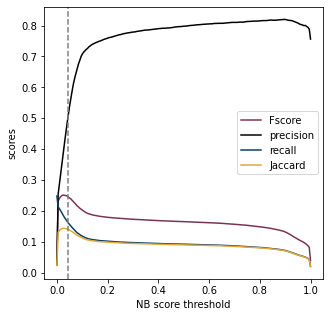

In [3]:
thresholds = np.linspace(0., 1., 200)
TS = ThresholdSelect('HCIP_pred_BioPlex_OP16.pkl', BP_edges, thresholds)
TS.explore_thresholds()
TS.draw()

Threshold: 0.045
Count unfiltered interactions: 620079
Count baits in unfiltered interactions: 3005
Count interactions HCIP (*bait-bait are counted twice): 20110
Count interactions filtered out by CompPASS Plus: 601258 (96.76359258925467% of unfiltered interactions)
Count interactions retained after CompPASS Plus: 20110 (3.2364074107453233% of unfiltered interactions)
Count HCIP baits: 2311
Count baits lost at CompPASS Plus: 694 (23.094841930116473% of unfiltered baits)
Count unique preys: 6301
count interactions with alts: 316
count unique alt preys:  261
count unique alt prey genes:  261
Count unique baits interacting with alts: 254
Count unique ref preys: 6040
Count unique all preys: 6301


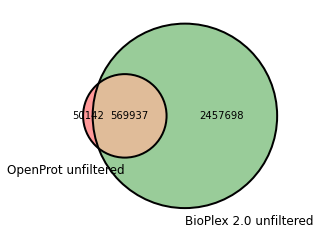

In [12]:
predictions = pickle.load(open('HCIP_pred_BioPlex_OP16.pkl', 'rb'))

thresh = 0.045
print('Threshold:', thresh)

unfiltered_interactions = set(frozenset((x[1], x[2])) for x in predictions)
print('Count unfiltered interactions:', len(unfiltered_interactions))
OP_baits = set([x[1] for x in predictions])
len(OP_baits)
print('Count baits in unfiltered interactions:', len(OP_baits))

HCIP = []
alt_compass_score = {}
for pred in predictions:
    batch, bait, prey, target, pnoint_pint = pred
    if pnoint_pint[1] < thresh: continue # select only intercations over pint threshold
    if bait == prey : continue # remove self loops      
    if is_alt(prey):
        alt_compass_score[(bait, prey)] = pnoint_pint[1]
    HCIP.append(pred)

print('Count interactions HCIP (*bait-bait are counted twice):', len(HCIP))
print('Count interactions filtered out by CompPASS Plus: {} ({}% of unfiltered interactions)'.format(
    len(predictions)-len(HCIP), 100*(len(predictions)-len(HCIP))/len(predictions)
))
print('Count interactions retained after CompPASS Plus: {} ({}% of unfiltered interactions)'.format(
    len(HCIP), 100*len(HCIP)/len(predictions)
))
HCIP_baits = set(bait for batch, bait, prey, target, pnoint_pint in HCIP)
print('Count HCIP baits:', len(HCIP_baits))
print(
    'Count baits lost at CompPASS Plus: {} ({}% of unfiltered baits)'.format(
        len([b for b in list(OP_baits) if b not in HCIP_baits]),
        100*len([b for b in list(OP_baits) if b not in HCIP_baits])/len(OP_baits)
    )
)
print('Count unique preys:', len(set(prey for batch, bait, prey, target, pnoint_pint in HCIP)))
print('count interactions with alts:', sum(is_alt(x[2]) for x in HCIP))
HCIP_alts = set(prey for batch, bait, prey, target, pnoint_pint in HCIP if is_alt(prey))
print('count unique alt preys: ', len(HCIP_alts))
print('count unique alt prey genes: ', len(set(x.split('|')[1] for x in list(HCIP_alts))))

HCIP_net = [(bait, prey, pnoint_pint[1]) for batch, bait, prey, target, pnoint_pint in HCIP]
print('Count unique baits interacting with alts:', len(set(b for b,p,pint in HCIP_net if is_alt(p))))
HCIP_refs = set(p for b,p,pint in HCIP_net if not is_alt(p))
print('Count unique ref preys:', len(HCIP_refs))
HCIP_preys = set(p for b,p,pint in HCIP_net)
print('Count unique all preys:', len(HCIP_preys))

data=[unfiltered_interactions, BP_unfiltered]
v=venn2(data, set_labels = ('OpenProt unfiltered', 'BioPlex 2.0 unfiltered'))
venn2_circles(data)
plt.savefig('bioplex_figures/OP_BP2_unfiltered.svg')
plt.show()

In [5]:
len(HCIP_refs.intersection(set(G_b.nodes())))/len(HCIP_refs)

0.8579470198675496

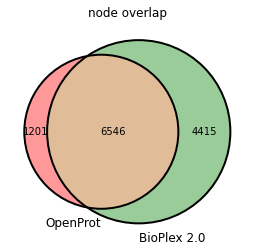

node overlap (as % of re-analysis result): 0.8449722473215439
Count total interactions: 19968
Count total ref-only interactions: 19652
Count total alt interactions: 316
BP2 Recalled interactions: 0.5097191125585182
BP3 Recalled interactions: 0.4935884388357419
count shared with BP3: 9700


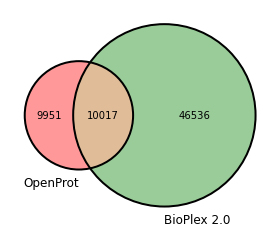

Bait median/mean degree: 5.0 9.717005625270446
Prey median/mean degree: 2.0 3.2155997056659307


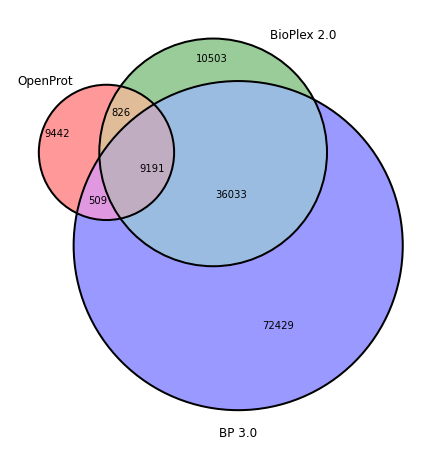

In [13]:
HCIP_net = [(bait, prey, pnoint_pint[1]) for batch, bait, prey, target, pnoint_pint in HCIP]

G_o = nx.Graph()
G_o.add_edges_from([(b, p) for b,p,pint in HCIP_net])
G_o.remove_edges_from(nx.selfloop_edges(G_o))
G_o.remove_nodes_from([k for k,v in G_o.degree() if v<1])

G_o_noalt = nx.Graph()
G_o_noalt.add_edges_from([(x[0], x[1]) for x in HCIP_net if not is_alt(x[1])])
G_o_noalt.remove_edges_from(nx.selfloop_edges(G_o_noalt))
G_o_noalt.remove_nodes_from([node for node, degree in G_o_noalt.degree() if degree<1])

G_o_edges = set(frozenset(e) for e in G_o.edges)
G_o_edges_noalts = set(frozenset(e) for e in G_o_noalt.edges)

nx.set_node_attributes(G_o, tt_type_node_attrs(G_o, HCIP_baits))
nx.set_node_attributes(G_o_noalt, tt_type_node_attrs(G_o_noalt, HCIP_baits))

data=[set(G_o.nodes()), set(G_b.nodes())]
v=venn2(data, set_labels = ('OpenProt', 'BioPlex 2.0'))
venn2_circles(data)
plt.title('node overlap')
plt.savefig('bioplex_figures/node_overlap_OP_BP2.svg')
plt.show()
print('node overlap (as % of re-analysis result):', len(set(G_o.nodes()).intersection(set(G_b.nodes())))/len(set(G_o.nodes())))

print('Count total interactions:', len(G_o_edges))
print('Count total ref-only interactions:', len(G_o_edges_noalts))
print('Count total alt interactions:', len([e for e in G_o.edges() if any(is_alt(n) for n in e)]))
print('BP2 Recalled interactions:', len(G_o_edges.intersection(G_b_edges))/len([e for e in G_o.edges() if not any(is_alt(n) for n in e)]))
print('BP3 Recalled interactions:', len(G_o_edges.intersection(bp3_net))/len([e for e in G_o.edges() if not any(is_alt(n) for n in e)]))
print('count shared with BP3:', len(G_o_edges.intersection(bp3_net)))

data=[G_o_edges, G_b_edges]
v=venn2(data, set_labels = ('OpenProt', 'BioPlex 2.0'))
venn2_circles(data)
plt.savefig('bioplex_figures/OP_BP2_overlap_venn_NB.svg')
plt.show()

deg = dict(G_o.degree)
bait_deg = [d for n,d in deg.items() if n in HCIP_baits]
prey_deg = [d for n,d in deg.items() if n not in HCIP_baits]
print('Bait median/mean degree:', np.median(bait_deg), np.mean(bait_deg))
print('Prey median/mean degree:', np.median(prey_deg), np.mean(prey_deg))

data=[G_o_edges, G_b_edges, bp3_net]
plt.figure(figsize=(8,8))
v=venn3(data, set_labels = ('OpenProt', 'BioPlex 2.0', 'BP 3.0'))
venn3_circles(data)
plt.savefig('bioplex_figures/OP_BP2_BP3_overlap_venn_NB.svg')
plt.show()

In [7]:
pickle.dump(G_o, open('G_o.pkl', 'wb'))
pickle.dump(G_o_noalt, open('G_o_noalt.pkl', 'wb'))
pickle.dump(G_o_edges, open('G_o_edges.pkl', 'wb'))
pickle.dump(HCIP_baits, open('HCIP_baits.pkl', 'wb'))